# Method 1: LSTM with Mel Spectrogram Preprocessing

**Uses same preprocessing as CNN methods:**
- Extract mel spectrograms directly from audio files
- GroupShuffleSplit by song ID
- Bidirectional LSTM architecture

In [1]:
import numpy as np
import librosa
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Bidirectional, Dense, Dropout, 
                                     BatchNormalization, GlobalAveragePooling1D)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

print(f'TensorFlow: {tf.__version__}')

TensorFlow: 2.15.0


## 1. Configuration

In [2]:
DATA_PATH = '../data/gtzan/genres_original'
SAMPLE_RATE = 22050
DURATION = 30
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512

GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop',
          'jazz', 'metal', 'pop', 'reggae', 'rock']
NUM_CLASSES = len(GENRES)

## 2. Feature Extraction (Same as CNN methods)

In [3]:
def extract_melspec(audio, sr):
    """
    Extract mel spectrogram - same preprocessing as CNN methods.
    Returns: (time_frames, n_mels) for LSTM input
    """
    mel = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)
    
    # Transpose to (time, frequency) for LSTM
    return mel_db.T

# Test
test_audio = np.random.randn(SAMPLE_RATE * 30)
test_features = extract_melspec(test_audio, SAMPLE_RATE)
print(f"Feature shape: {test_features.shape}")  # (time_frames, 128)

Feature shape: (1292, 128)


## 3. Load Dataset

In [4]:
def load_dataset(data_path, target_length=1291):
    """
    Load GTZAN and extract mel spectrograms.
    """
    X, y, song_ids = [], [], []
    
    for genre in GENRES:
        genre_path = os.path.join(data_path, genre)
        if not os.path.exists(genre_path):
            continue
        
        files = sorted([f for f in os.listdir(genre_path) if f.endswith('.wav')])
        
        for filename in tqdm(files, desc=f"{genre}"):
            if 'jazz.00054' in filename:
                continue
            
            filepath = os.path.join(genre_path, filename)
            song_id = f"{genre}.{filename.split('.')[1]}"
            
            try:
                audio, sr = librosa.load(filepath, sr=SAMPLE_RATE, duration=DURATION)
                
                # Pad to exact duration
                target_samples = SAMPLE_RATE * DURATION
                if len(audio) < target_samples:
                    audio = np.pad(audio, (0, target_samples - len(audio)))
                
                # Extract mel spectrogram
                melspec = extract_melspec(audio, sr)
                
                # Pad/truncate to target length
                if melspec.shape[0] < target_length:
                    pad_width = target_length - melspec.shape[0]
                    melspec = np.pad(melspec, ((0, pad_width), (0, 0)))
                else:
                    melspec = melspec[:target_length, :]
                
                X.append(melspec)
                y.append(genre)
                song_ids.append(song_id)
                
            except Exception as e:
                print(f"Error: {filename}: {e}")
    
    return np.array(X), np.array(y), np.array(song_ids)

print("Loading dataset...")
X, y, song_ids = load_dataset(DATA_PATH)
print(f"\nDataset shape: {X.shape}")
print(f"Unique songs: {len(np.unique(song_ids))}")

Loading dataset...


rock: 100%|██████████| 100/100 [00:01<00:00, 54.39it/s]



Dataset shape: (999, 1291, 128)
Unique songs: 999


## 4. GroupShuffleSplit by Song ID

In [5]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_cat = to_categorical(y_encoded, NUM_CLASSES)

# Split by song: 80% train, 10% val, 10% test
splitter = GroupShuffleSplit(test_size=0.20, n_splits=1, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, song_ids))

X_train_full, X_test = X[train_idx], X[test_idx]
y_train_full, y_test = y_cat[train_idx], y_cat[test_idx]
songs_train = song_ids[train_idx]

# Split train into train/val
splitter_val = GroupShuffleSplit(test_size=0.125, n_splits=1, random_state=42)
train_idx2, val_idx = next(splitter_val.split(X_train_full, y_train_full, songs_train))

X_train = X_train_full[train_idx2]
X_val = X_train_full[val_idx]
y_train = y_train_full[train_idx2]
y_val = y_train_full[val_idx]

print(f"Train: {X_train.shape}")
print(f"Val: {X_val.shape}")
print(f"Test: {X_test.shape}")

Train: (699, 1291, 128)
Val: (100, 1291, 128)
Test: (200, 1291, 128)


## 5. Normalization

In [6]:
# Normalize using training statistics
mean = X_train.mean()
std = X_train.std()

X_train = (X_train - mean) / (std + 1e-8)
X_val = (X_val - mean) / (std + 1e-8)
X_test = (X_test - mean) / (std + 1e-8)

# Save normalization params for inference
np.savez('../models/lstm_norm_params.npz', mean=mean, std=std)

print(f"LSTM input shape: {X_train.shape}")

LSTM input shape: (699, 1291, 128)


## 6. Build LSTM Model

In [7]:
def build_lstm_model(input_shape, num_classes):
    model = Sequential([
        # Bidirectional LSTM layers
        Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        
        # Global pooling over time
        GlobalAveragePooling1D(),
        
        # Dense layers
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(64, activation='relu'),
        Dropout(0.3),
        
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Input shape: (time_steps, features) = (1291, 128)
model = build_lstm_model((X_train.shape[1], X_train.shape[2]), NUM_CLASSES)
model.summary()

2025-12-07 19:42:54.218518: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-12-07 19:42:54.218541: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-12-07 19:42:54.218552: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.88 GB
2025-12-07 19:42:54.218588: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-07 19:42:54.218601: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1291, 256)         263168    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1291, 256)         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 1291, 128)         164352    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 1291, 128)         0         
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                        

## 7. Training

In [8]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


2025-12-07 19:42:56.237581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-12-07 19:42:56.386008: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


44/44 [==============================] - 15s 278ms/step - loss: 2.8489 - accuracy: 0.2217 - val_loss: 2.0138 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - 10s 235ms/step - loss: 2.3347 - accuracy: 0.3076 - val_loss: 1.9570 - val_accuracy: 0.3200 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - 10s 236ms/step - loss: 2.1596 - accuracy: 0.3062 - val_loss: 1.9115 - val_accuracy: 0.3400 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - 11s 239ms/step - loss: 2.0663 - accuracy: 0.3233 - val_loss: 1.8845 - val_accuracy: 0.2900 - lr: 0.0010
Epoch 5/100
44/44 [==============================] - 10s 236ms/step - loss: 1.8856 - accuracy: 0.3891 - val_loss: 1.7579 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 6/100
44/44 [==============================] - 10s 236ms/step - loss: 1.7802 - accuracy: 0.4263 - val_loss: 1.7632 - val_accuracy: 0.3600 - lr: 0.0010
Epoch 7/100
44/44 [==============================] - 10s 236ms/step - 

## 8. Evaluation

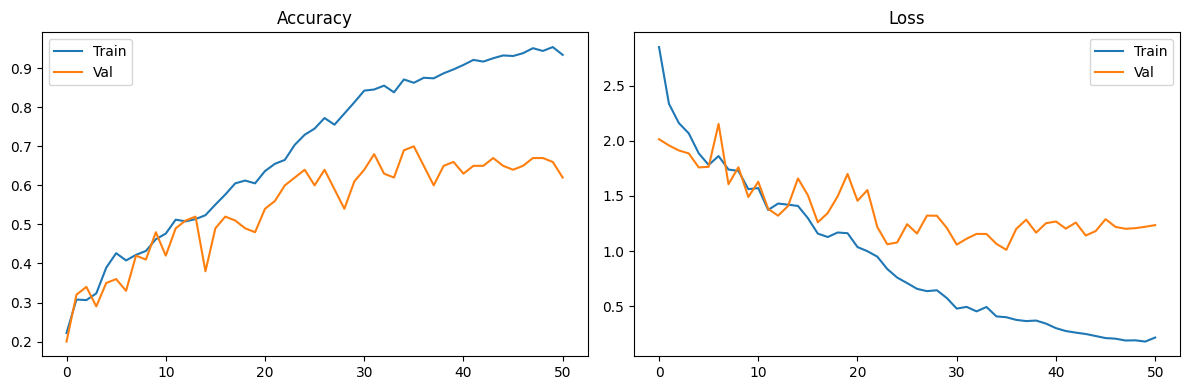


Test Accuracy: 71.50%
7/7 [==============================] - 1s 75ms/step

Classification Report:
              precision    recall  f1-score   support

       blues       0.76      0.76      0.76        21
   classical       0.60      1.00      0.75        12
     country       0.68      0.62      0.65        24
       disco       0.60      0.55      0.57        22
      hiphop       0.87      0.87      0.87        15
        jazz       0.90      0.67      0.77        27
       metal       0.89      0.94      0.92        18
         pop       0.80      0.84      0.82        19
      reggae       0.68      0.68      0.68        22
        rock       0.43      0.45      0.44        20

    accuracy                           0.71       200
   macro avg       0.72      0.74      0.72       200
weighted avg       0.72      0.71      0.71       200



In [9]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history.history['accuracy'], label='Train')
axes[0].plot(history.history['val_accuracy'], label='Val')
axes[0].set_title('Accuracy')
axes[0].legend()

axes[1].plot(history.history['loss'], label='Train')
axes[1].plot(history.history['val_loss'], label='Val')
axes[1].set_title('Loss')
axes[1].legend()
plt.tight_layout()
plt.show()

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

## 9. Save Model

In [10]:
model.save('../models/lstm_melspec.keras')
print("Model saved to ../models/lstm_melspec.keras")
print("Normalization params saved to ../models/lstm_norm_params.npz")

Model saved to ../models/lstm_melspec.keras
Normalization params saved to ../models/lstm_norm_params.npz
